# Imports

In [ ]:
from collections import defaultdict
import datetime
import json
import os
import random

import emoji
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from textblob import TextBlob


RANDOM_STATE=0
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

drive.mount("/content/drive")
# os.chdir("/content/drive/MyDrive/courses/masters/winter 24/ece 219/project 4")
os.chdir("/content/drive/MyDrive/ece 219/project 4")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 2.8 MB/s eta 0:00:00


# Pre-process Data

In [ ]:
diamond_data = pd.read_csv("diamond data/diamonds.csv")
diamond_data = diamond_data.drop("Unnamed: 0", axis=1)
diamond_data.head()

,color,clarity,carat,cut,symmetry,polish,depth_percent,table_percent,length,width,depth,girdle_min,girdle_max,price
0,E,VVS2,0.09,Excellent,Very Good,Very Good,62.7,59.0,2.85,2.87,1.79,M,M,200
1,E,VVS2,0.09,Very Good,Very Good,Very Good,61.9,59.0,2.84,2.89,1.78,STK,STK,200
2,E,VVS2,0.09,Excellent,Very Good,Very Good,61.1,59.0,2.88,2.90,1.77,TN,M,200
3,E,VVS2,0.09,Excellent,Very Good,Very Good,62.0,59.0,2.86,2.88,1.78,M,STK,200
4,E,VVS2,0.09,Very Good,Very Good,Excellent,64.9,58.5,2.79,2.83,1.82,STK,STK,200


In [ ]:
encoder = OneHotEncoder(sparse_output=False)

categorical_columns = [
    "color", "clarity", "cut", "symmetry", "polish", "girdle_min", "girdle_max",
]
numeric_columns = [
    "carat", "depth_percent", "table_percent", "length", "width", "depth", "price",
]

# One hot encode categorical columns
encoded_data = encoder.fit_transform(diamond_data[categorical_columns])
categorical_feature_names = encoder.get_feature_names_out(categorical_columns)
categorical_df = pd.DataFrame(encoded_data, columns=categorical_feature_names)

# Extract numeric columns
numeric_df = diamond_data[numeric_columns]

# Concatenate columns for final dataset
diamond_data_processed = pd.concat([numeric_df, categorical_df], axis=1)

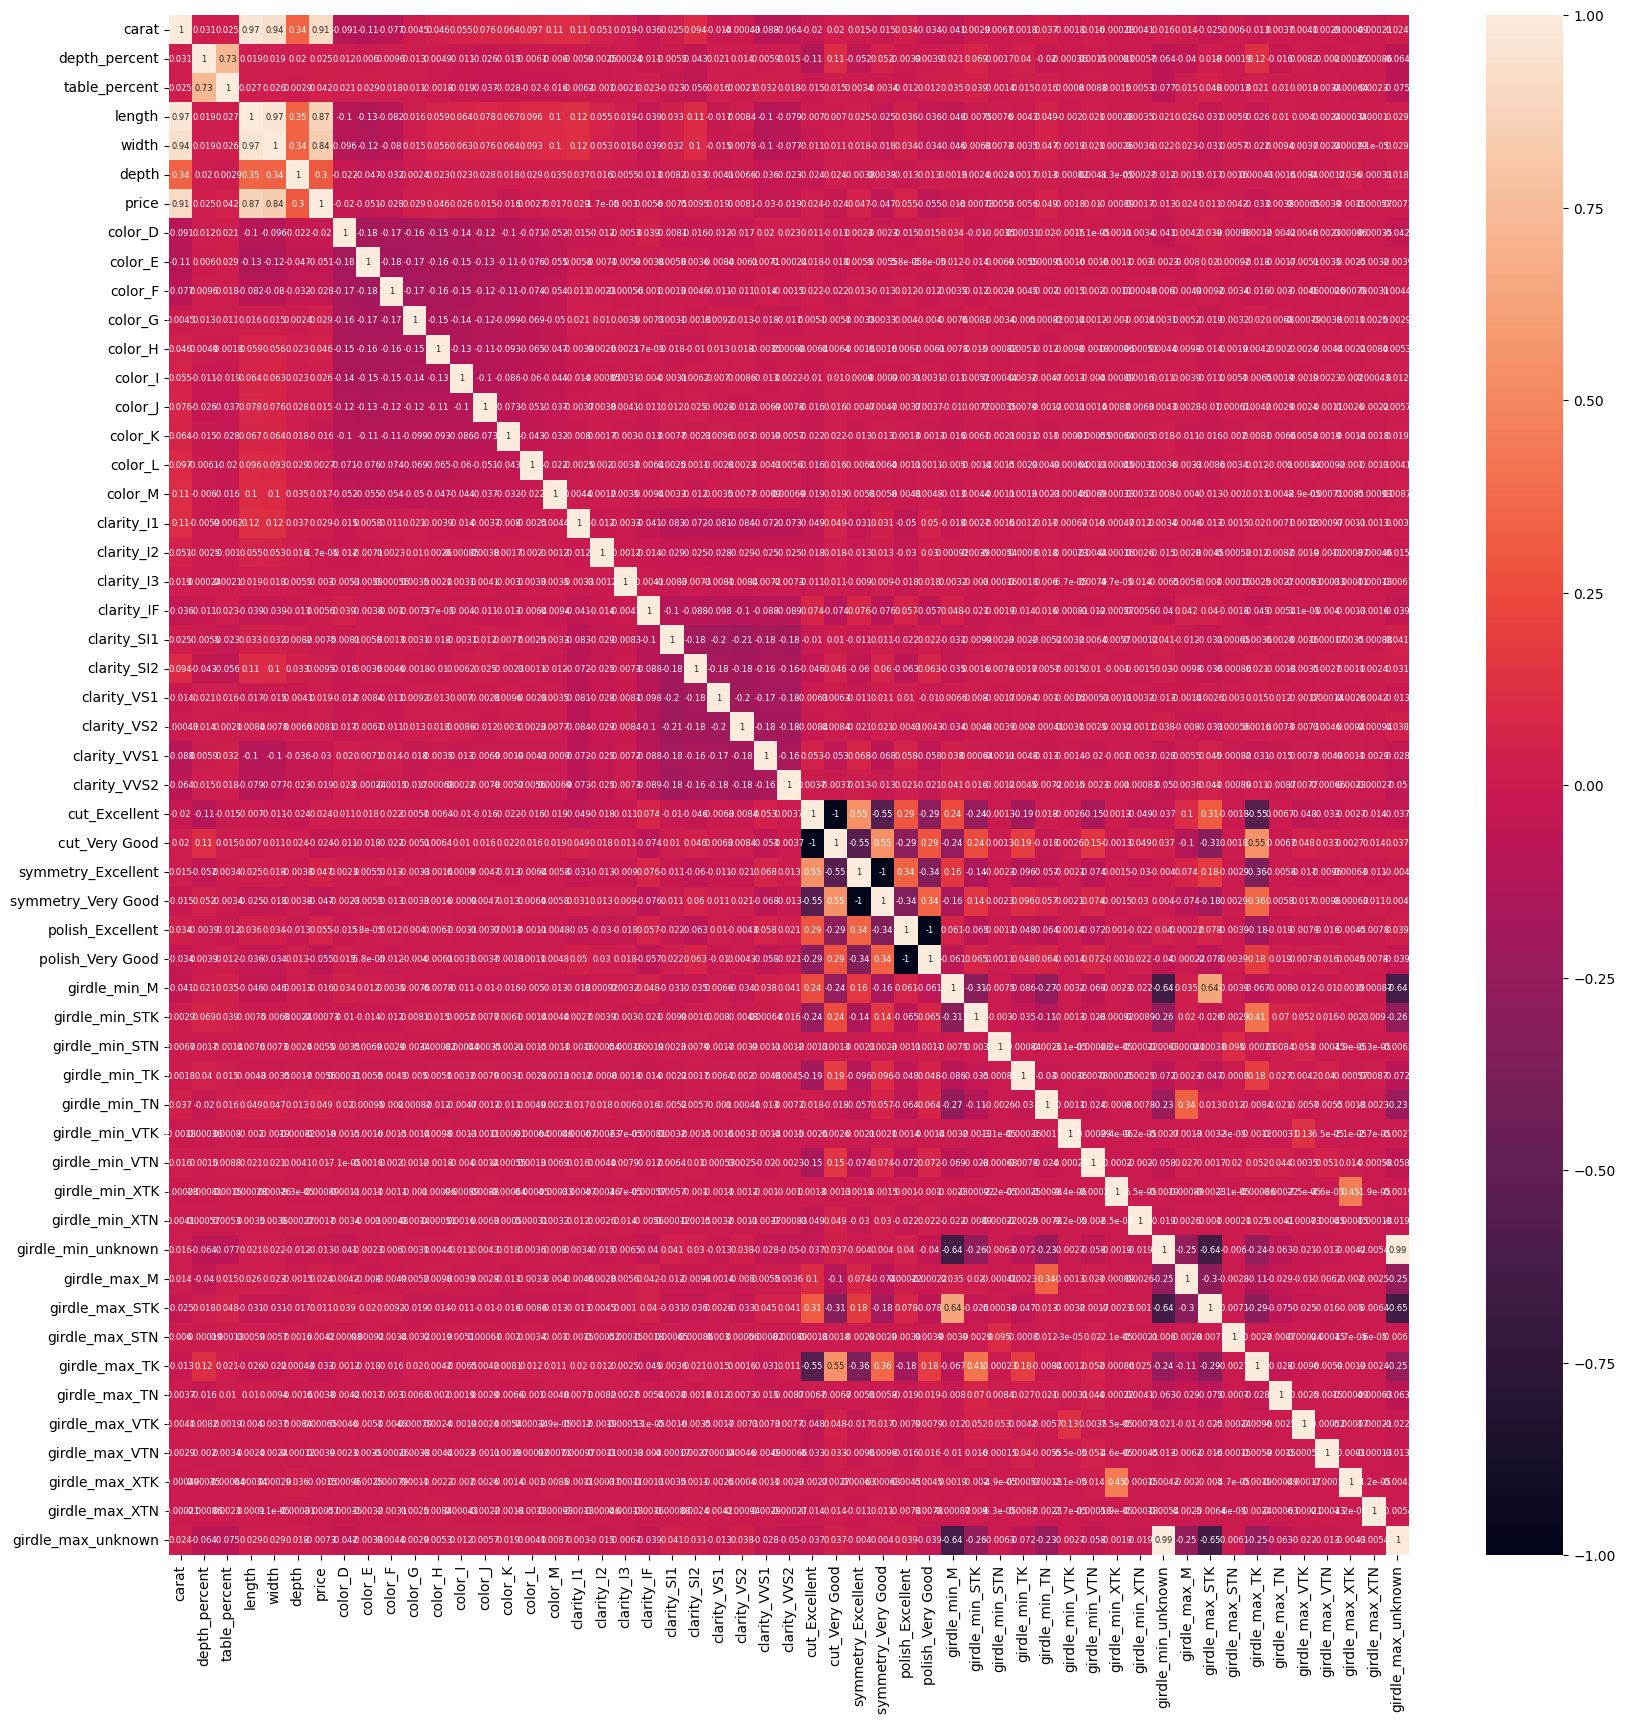

In [ ]:
corr_matrix = diamond_data_processed.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sn.heatmap(corr_matrix, annot=True, annot_kws={"size": 6})
plt.show()

# Visualize Data

In [ ]:
for column in numeric_columns:
  data = diamond_data_processed[[column]]

  plt.hist(data, bins=10)
  plt.title(f"Histogram of Feature: {column}")
  plt.xlabel(f"{column}")
  plt.ylabel("Frequency")
  plt.show()

In [ ]:
for column in categorical_columns:
  plt.figure(figsize=(8, 6))
  sn.boxplot(x=column, y="price", data=diamond_data)
  plt.title(f"Boxplot of {column} vs Price")
  plt.show()

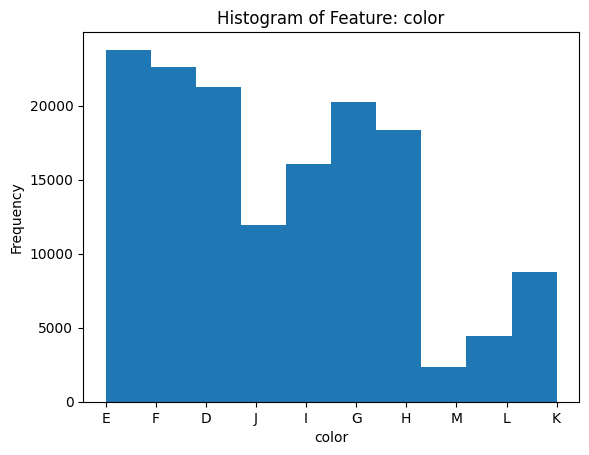

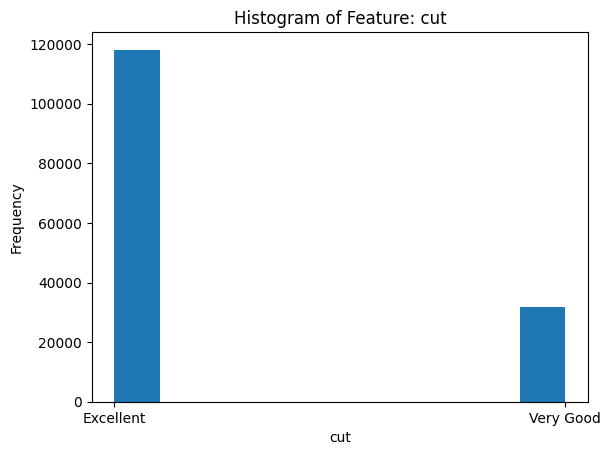

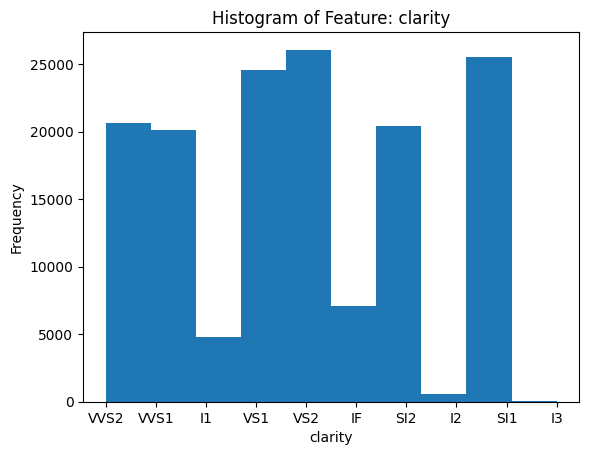

In [ ]:
for column in ["color", "cut", "clarity"]:
  plt.hist(diamond_data[column], bins=10)
  plt.title(f"Histogram of Feature: {column}")
  plt.xlabel(f"{column}")
  plt.ylabel("Frequency")
  plt.show()

# Scaling and Feature Selection

In [ ]:
# Scaling data

scaler = StandardScaler()
scaled_data = scaler.fit_transform(diamond_data_processed)
diamond_data_scaled = pd.DataFrame(scaled_data, columns=diamond_data_processed.columns)

diamond_data_scaled.head()

,carat,depth_percent,table_percent,length,width,depth,price,color_D,color_E,color_F,...,girdle_max_M,girdle_max_STK,girdle_max_STN,girdle_max_TK,girdle_max_TN,girdle_max_VTK,girdle_max_VTN,girdle_max_XTK,girdle_max_XTN,girdle_max_unknown
0,-1.157106,0.215866,0.345119,-2.146391,-2.078247,-0.730430,-0.659094,-0.406722,2.302809,-0.421735,...,2.909902,-0.873049,-0.008169,-0.331314,-0.085633,-0.029122,-0.017899,-0.005776,-0.007306,-0.740798
1,-1.157106,0.014689,0.345119,-2.156289,-2.059209,-0.735681,-0.659094,-0.406722,2.302809,-0.421735,...,-0.343654,1.145412,-0.008169,-0.331314,-0.085633,-0.029122,-0.017899,-0.005776,-0.007306,-0.740798
2,-1.157106,-0.186488,0.345119,-2.116697,-2.049690,-0.740932,-0.659094,-0.406722,2.302809,-0.421735,...,2.909902,-0.873049,-0.008169,-0.331314,-0.085633,-0.029122,-0.017899,-0.005776,-0.007306,-0.740798
3,-1.157106,0.039836,0.345119,-2.136493,-2.068728,-0.735681,-0.659094,-0.406722,2.302809,-0.421735,...,-0.343654,1.145412,-0.008169,-0.331314,-0.085633,-0.029122,-0.017899,-0.005776,-0.007306,-0.740798
4,-1.157106,0.769101,0.218693,-2.205778,-2.116324,-0.714676,-0.659094,-0.406722,2.302809,-0.421735,...,-0.343654,1.145412,-0.008169,-0.331314,-0.085633,-0.029122,-0.017899,-0.005776,-0.007306,-0.740798


In [ ]:
X = diamond_data_scaled.drop("price", axis=1)
y = diamond_data_scaled["price"]

In [ ]:
# Mutual Information (MI) Scores

mi_scores = mutual_info_regression(X, y)
print (sorted(mi_scores, reverse=True))

[1.3758451225938826, 1.2038888286132954, 1.1922157946907035, 1.16025096459291, 0.04358690519455699, 0.042237931462009826, 0.029889848319377688, 0.029110418619159972, 0.028283162481850255, 0.027765747026348375, 0.027091962461432306, 0.0270414281262763, 0.027018722616062085, 0.026164598901808223, 0.02563053475649868, 0.02533237267219768, 0.024573958590005773, 0.0244740996501438, 0.023632929630058364, 0.02315301204991771, 0.02217053587275375, 0.021682449652328906, 0.02148122554671472, 0.018021789308006575, 0.01791519897135707, 0.017709278936663964, 0.015652145364072556, 0.015044371864546768, 0.014539045793816374, 0.013926748125014043, 0.012074980427637438, 0.010737799135183579, 0.01052329321585077, 0.009931843134857843, 0.007492220808180683, 0.004841628097028483, 0.004079634134050991, 0.003636444317200116, 0.0028400995165558385, 0.002592191816112699, 0.001842845301584184, 0.001438542653901198, 0.0008960257207570876, 0.0008502880704224225, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
lowest_mi_score_indices = np.argsort(mi_scores)[:2]
lowest_mi_score_features = X.columns[lowest_mi_score_indices]
print (lowest_mi_score_features)

Index(['girdle_min_VTN', 'girdle_max_VTN'], dtype='object')


In [ ]:
# Select top MI scores

selector = SelectKBest(mutual_info_regression, k=4)
selector.fit(X, y)
selected_feature_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_feature_indices]
print (selected_features)
X_selected = X[selected_features]

Index(['carat', 'length', 'width', 'depth'], dtype='object')


In [ ]:
X_selected = X[selected_features]
print(X_selected)

           carat    length     width     depth
0      -1.157106 -2.146391 -2.078247 -0.730430
1      -1.157106 -2.156289 -2.059209 -0.735681
2      -1.157106 -2.116697 -2.049690 -0.740932
3      -1.157106 -2.136493 -2.068728 -0.735681
4      -1.157106 -2.205778 -2.116324 -0.714676
...          ...       ...       ...       ...
149866  3.631605  2.931233  2.833676  0.981472
149867  3.357252  2.772867  2.681369  0.913206
149868  4.729018  3.525108  3.423869  1.102251
149869  4.853724  3.742861  3.614253  1.070743
149870  2.359604  2.208686  2.138772  0.734664

[149871 rows x 4 columns]


# Cross Validation Setup

In [ ]:
def cross_validation(model, X, y, n_splits, random_state=RANDOM_STATE):
  """Perform KFold cross validation when given a model, features, targets. Not actually used in this project because we need access to model params which cross_val_score does not provide."""
  kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
  scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf, n_jobs=-1)
  scores = np.abs(scores)
  rmse_scores = np.sqrt(scores)
  avg_rmse = np.mean(rmse_scores)
  return avg_rmse

# Linear Regression

In [ ]:
# OLS

X_with_constant = sm.add_constant(X_selected)
kf = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
rmses = []
learned_params = {param: 0 for param in X_with_constant.columns} # map param name to sum of learned params

for train_index, test_index in kf.split(X_with_constant):
    X_train, X_test = X_with_constant.iloc[train_index], X_with_constant.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = sm.OLS(y_train, X_train).fit()

    assert (len(model.params) == len(learned_params))
    for param_name, param_val in model.params.items():
      learned_params[param_name] += param_val

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

print (f"KFold RMSEs (OLS):", rmses)

avg_rmse = np.mean(rmses)
print (f"Average RMSE (OLS): {avg_rmse}")

learned_params = {name: val / 10 for name, val in learned_params.items()}
print (f"Average learned params (OLS): {learned_params}")

KFold RMSEs (OLS): [0.4120694770113099, 0.4116124073045246, 0.39568841249477127, 0.3921686369444565, 0.38101165792085206, 0.4215895567391148, 0.3945409019130487, 0.3970243383233593, 0.40355557750461, 0.3829158566729027]
Average RMSE (OLS): 0.3992176822828949
Average learned params (OLS): {'const': 1.207573380160548e-07, 'carat': 1.2349678204938752, 'length': -0.319235435923662, 'width': -0.010591549849219908, 'depth': -0.0036583501957502236}


In [ ]:
# Find best alpha

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=RANDOM_STATE)

alphas = [0.01, 0.1, 1, 5, 20, 100]
best_alpha = None
best_score = 0
for alpha in alphas:
  lasso = Lasso(alpha=alpha)
  lasso.fit(X_train, y_train)
  test_score = lasso.score(X_test, y_test)
  if test_score > best_score:
    best_score = test_score
    best_alpha = alpha

print (f"Best alpha: {best_alpha}")
print (f"Best score: {best_score}")

Best alpha: 0.01
Best score: 0.8312086217175065


In [ ]:
# Lasso regression

X_with_constant = sm.add_constant(X_selected)
coef_idx_to_param_name = {i: name for i, name in enumerate(X_with_constant.columns)}
kf = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
rmses = []
learned_params = {param: 0 for param in X_with_constant.columns} # map param name to sum of learned params

for train_index, test_index in kf.split(X_with_constant):
    X_train, X_test = X_with_constant.iloc[train_index], X_with_constant.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train, y_train)

    assert (len(lasso.coef_) == len(learned_params))
    for i, param_val in enumerate(lasso.coef_):
      param_name = coef_idx_to_param_name[i]
      learned_params[param_name] += param_val

    y_pred = lasso.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

print (f"KFold RMSEs (Lasso):", rmses)

avg_rmse = np.mean(rmses)
print (f"Average RMSE (Lasso): {avg_rmse}")

learned_params = {name: val / 10 for name, val in learned_params.items()}
print (f"Average learned params (Lasso): {learned_params}")

KFold RMSEs (Lasso): [0.41757767857442635, 0.416242518647826, 0.4047817893108982, 0.4004225336505694, 0.3894888101857386, 0.42791737396803226, 0.4016217662713657, 0.40712335895912943, 0.4105091977921818, 0.3930330941190847]
Average RMSE (Lasso): 0.4068718121479253
Average learned params (Lasso): {'const': 0.0, 'carat': 0.9034803355841561, 'length': 0.0, 'width': 0.0, 'depth': 0.0}


In [ ]:
# Find best alpha

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=RANDOM_STATE)

alphas = [0.01, 0.1, 1, 5, 20, 100]
best_alpha = None
best_score = 0
for alpha in alphas:
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_train, y_train)
  test_score = ridge.score(X_test, y_test)
  if test_score > best_score:
    best_score = test_score
    best_alpha = alpha

print (f"Best alpha: {best_alpha}")
print (f"Best score: {best_score}")

Best alpha: 100
Best score: 0.8353455841138269


In [ ]:
# Ridge regression

X_with_constant = sm.add_constant(X_selected)
coef_idx_to_param_name = {i: name for i, name in enumerate(X_with_constant.columns)}
kf = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
rmses = []
learned_params = {param: 0 for param in X_with_constant.columns} # map param name to sum of learned params
r2s = []

for train_index, test_index in kf.split(X_with_constant):
    X_train, X_test = X_with_constant.iloc[train_index], X_with_constant.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train, y_train)

    assert (len(ridge.coef_) == len(learned_params))
    for i, param_val in enumerate(ridge.coef_):
      param_name = coef_idx_to_param_name[i]
      learned_params[param_name] += param_val

    y_pred = ridge.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

    r2 = r2_score(y_test, y_pred)
    r2s.append(r2)

print (f"KFold RMSEs (Ridge):", rmses)

avg_rmse = np.mean(rmses)
print (f"Average RMSE (Ridge): {avg_rmse}")

learned_params = {name: val / 10 for name, val in learned_params.items()}
print (f"Average learned params (Ridge): {learned_params}")

avg_r2_score = np.mean(r2s)
print (f"Average r2 score (Ridge): {avg_r2_score}")

KFold RMSEs (Ridge): [0.4119721905016644, 0.41140019436534786, 0.39583649183487873, 0.3922386805018174, 0.38107432106922917, 0.4215664859301681, 0.3945205849981671, 0.3972665163569926, 0.40351529819508325, 0.3831028929177979]
Average RMSE (Ridge): 0.39924936566711466
Average learned params (Ridge): {'const': 0.0, 'carat': 1.2148943139233737, 'length': -0.2967209873980527, 'width': -0.013421872956992867, 'depth': -0.0037921271877426757}
Average r2 score (Ridge): 0.8405696895847046


In [ ]:
X_unscaled = diamond_data_processed.drop("price", axis=1)
y_unscaled = diamond_data_processed["price"]

X_unscaled_selected = X_unscaled[selected_features]

In [ ]:
# Ridge regression with unscaled data

X_with_constant = sm.add_constant(X_unscaled_selected)
coef_idx_to_param_name = {i: name for i, name in enumerate(X_with_constant.columns)}
kf = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
rmses = []
learned_params = {param: 0 for param in X_with_constant.columns} # map param name to sum of learned params
r2s = []

for train_index, test_index in kf.split(X_with_constant):
    X_train, X_test = X_with_constant.iloc[train_index], X_with_constant.iloc[test_index]
    y_train, y_test = y_unscaled.iloc[train_index], y_unscaled.iloc[test_index]

    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train, y_train)

    assert (len(ridge.coef_) == len(learned_params))
    for i, param_val in enumerate(ridge.coef_):
      param_name = coef_idx_to_param_name[i]
      learned_params[param_name] += param_val

    y_pred = ridge.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

    r2 = r2_score(y_test, y_pred)
    r2s.append(r2)

print (f"KFold RMSEs (Ridge):", rmses)

avg_rmse = np.mean(rmses)
print (f"Average RMSE (Ridge): {avg_rmse}")

learned_params = {name: val / 10 for name, val in learned_params.items()}
print (f"Average learned params (Ridge): {learned_params}")

avg_r2_score = np.mean(r2s)
print (f"Average r2 score (Ridge): {avg_r2_score}")

KFold RMSEs (Ridge): [1940.3483077311005, 1936.1888807998805, 1869.1949909764207, 1850.8703876864622, 1798.3708935467223, 1986.9528256932406, 1860.1153021531297, 1877.3335855234222, 1902.2671874159857, 1810.2065506806443]
Average RMSE (Ridge): 1883.1848912207006
Average learned params (Ridge): {'const': 0.0, 'carat': 13359.302496277023, 'length': -1042.407235002865, 'width': -49.71349800397393, 'depth': -9.810422679365487}
Average r2 score (Ridge): 0.8400672908628541


# Polynomial Regression

In [ ]:
# Find best polynomial degree

degrees = [2, 3, 4, 5, 6]

best_degree = None
best_score = 0
for degree in degrees:
  poly_features = PolynomialFeatures(degree=degree)
  X_selected_transformed = poly_features.fit_transform(X_selected)

  X_train, X_test, y_train, y_test = train_test_split(X_selected_transformed, y, test_size=0.2, random_state=RANDOM_STATE)

  ridge = Ridge(alpha=100)
  ridge.fit(X_train, y_train)
  test_score = ridge.score(X_test, y_test)
  if test_score > best_score:
    best_score = test_score
    best_degree = degree

print (f"Best degree: {best_degree}")
print (f"Best score: {best_score}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.17963e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Best degree: 2
Best score: 0.8561574009223102


In [ ]:
# Ridge regression on polynomial-transformed data

poly_features = PolynomialFeatures(degree=2)
X_selected_transformed = poly_features.fit_transform(X_selected)
feature_names = poly_features.get_feature_names_out()

X_with_constant = X_selected_transformed
coef_idx_to_param_name = {i: name for i, name in enumerate(feature_names)}
kf = KFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)
rmses = []
learned_params = {param: 0 for param in feature_names}
r2s = []

for train_index, test_index in kf.split(X_with_constant):
    X_train, X_test = X_with_constant[train_index], X_with_constant[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    ridge = Ridge(alpha=best_alpha)
    ridge.fit(X_train, y_train)

    assert (len(ridge.coef_) == len(learned_params))
    for i, param_val in enumerate(ridge.coef_):
      param_name = coef_idx_to_param_name[i]
      learned_params[param_name] += param_val

    y_pred = ridge.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

    r2 = r2_score(y_test, y_pred)
    r2s.append(r2)

print (f"KFold RMSEs (Ridge):", rmses)

avg_rmse = np.mean(rmses)
print (f"Average RMSE (Ridge): {avg_rmse}")

learned_params = {name: val / 10 for name, val in learned_params.items()}
print (f"Average learned params (Ridge): {learned_params}")

avg_r2_score = np.mean(r2s)
print (f"Average r2 score (Ridge): {avg_r2_score}")

KFold RMSEs (Ridge): [0.38156916889065184, 0.3854905641633543, 0.3751582186551391, 0.3716909337605128, 0.3553934614581562, 0.3905472805231524, 0.3695341050647724, 0.3767663454693769, 0.3793709505310369, 0.3637224833751296]
Average RMSE (Ridge): 0.3749243511891282
Average learned params (Ridge): {'1': 0.0, 'carat': 0.3008469302529113, 'length': 0.1208375632194754, 'width': 0.18932772958539335, 'depth': 0.026360794221534967, 'carat^2': -0.36464598202778864, 'carat length': 0.3429282350910052, 'carat width': 0.35425433883704316, 'carat depth': 0.004833868217729844, 'length^2': 0.131626392351658, 'length width': -0.2169652742131773, 'length depth': 0.012807652957123055, 'width^2': -0.0039545636732161394, 'width depth': -0.02192215207974793, 'depth^2': -0.000754661827148128}
Average r2 score (Ridge): 0.8594052265724403


# Neural Network

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.2, random_state = 42)

mlp = MLPRegressor(max_iter=1000)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

pipeline = Pipeline([
    ('mlp', mlp)
])

param_grid = {
    'mlp__hidden_layer_sizes': [(8,), (12,), (16,), (8, 4), (12, 6), (16, 8), (10, 10), (10, 10, 5)],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
}

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=rmse_scorer, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation RMSE: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: ", rmse)

Best parameters found:  {'mlp__hidden_layer_sizes': (12, 6), 'mlp__alpha': 0.01}
Best cross-validation RMSE:  -0.37052294548676334
Test RMSE:  0.3764060721524689


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=100,
                                     max_features='auto',
                                     max_depth=4,
                                     random_state=42,
                                     oob_score=True)

rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: ", rmse)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Test RMSE:  0.3558660713475074


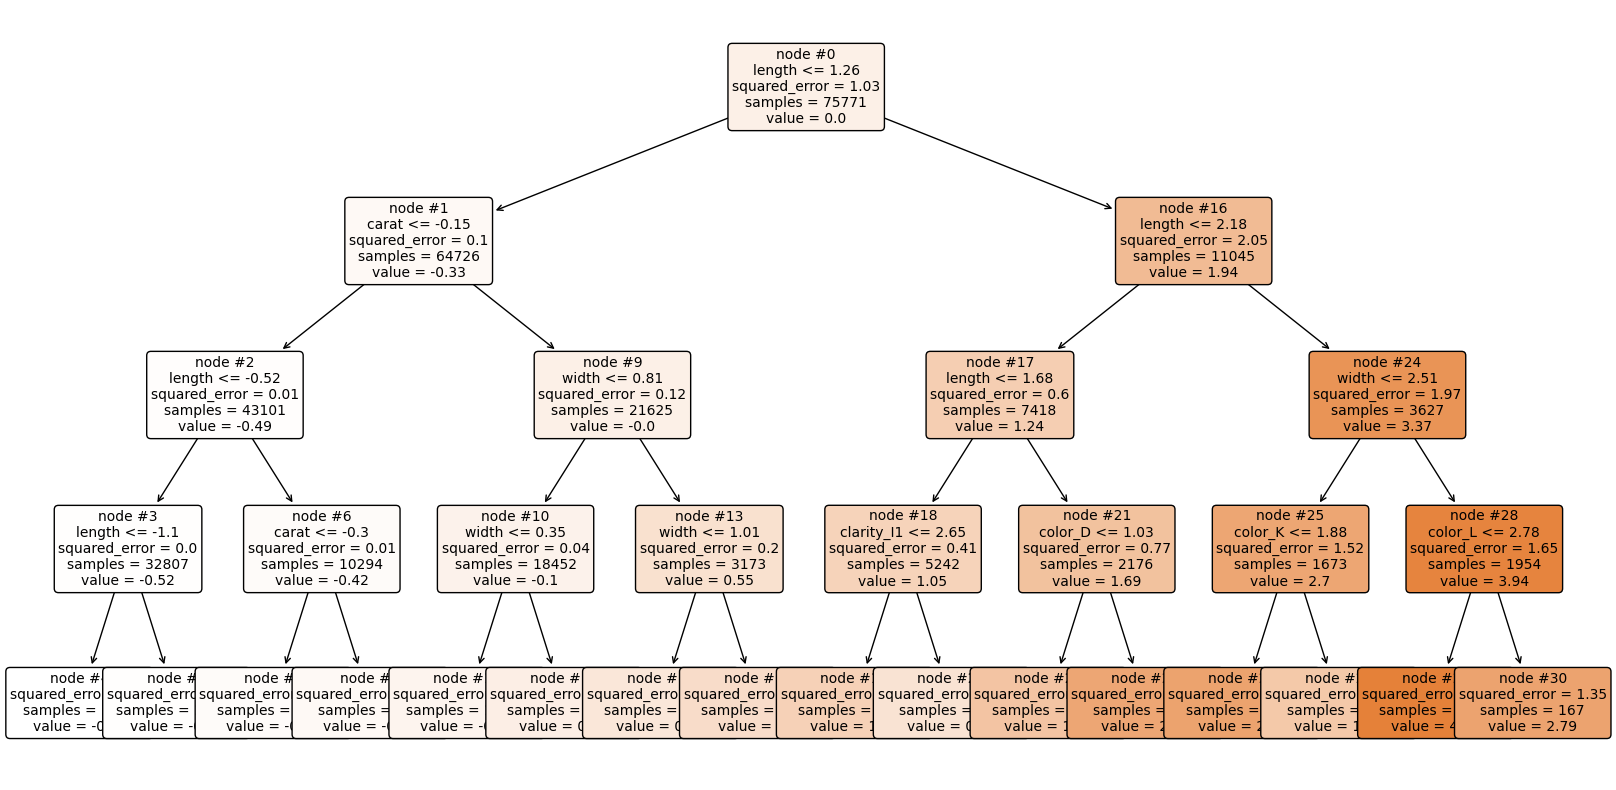

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

random_tree = rf_regressor.estimators_[np.random.randint(0, 100)]

plt.figure(figsize=(20, 10))
plot_tree(random_tree, filled=True, feature_names=X.columns, rounded=True, precision=2, node_ids=True, fontsize=10)
plt.show()

In [ ]:
oob_error = 1 - rf_regressor.oob_score_
print("OOB Error: ", oob_error)

y_pred = rf_regressor.predict(X)
r2 = r2_score(y, y_pred)
print("R^2 Score: ", r2)

OOB Error:  0.12551211047396027
R^2 Score:  0.8756231353967725


# LightGBM, CatBoost, and Bayesian Optimization

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 10.1 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from catboost import CatBoostRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

search_spaces = {
    'depth': Integer(4, 8),
    'learning_rate': Real(0.01, 0.2, 'uniform'),
    'iterations': Integer(100, 500),
    'l2_leaf_reg': Integer(1, 10),
}

cb_regressor = CatBoostRegressor(loss_function='RMSE', random_seed=42, verbose=False)

bayes_search = BayesSearchCV(estimator=cb_regressor,
                             search_spaces=search_spaces,
                             n_iter=32,
                             cv=3,
                             scoring='neg_root_mean_squared_error',
                             n_jobs=1,
                             random_state=42)
np.int = int
bayes_search.fit(X_train, y_train)

print("Best parameters found: ", bayes_search.best_params_)
best_rmse = -bayes_search.best_score_
print("Best RMSE from CV: ", best_rmse)

best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE with optimized hyperparameters: {test_rmse}")




Best parameters found:  OrderedDict([('depth', 8), ('iterations', 500), ('l2_leaf_reg', 1), ('learning_rate', 0.09985577822694015)])
Best RMSE from CV:  0.13210428775924388
Test RMSE with optimized hyperparameters: 0.1272260996897493


# Twitter Data Task Design

In [ ]:
# Process all files except superbowl file due to large file size (consumes all memory)

files = [
  # "tweet data/tweets_#gohawks.txt",
  # "tweet data/tweets_#gopatriots.txt",
  "tweet data/tweets_#nfl.txt",
  # "tweet data/tweets_#patriots.txt",
  # "tweet data/tweets_#sb49.txt",
]

for fname in files:
  with open(fname, "r") as f:
    data = f.read().strip().split("\n")

  num_tweets = len(data)

  first_tweet_time = None
  last_tweet_time = None

  num_users = len(data)
  total_user_followers = 0

  total_num_retweets = 0
  for tweet in data:
    tweet_obj = json.loads(tweet)

    tweet_time_unix = tweet_obj["firstpost_date"]
    tweet_time_dt = datetime.datetime.fromtimestamp(tweet_time_unix)
    if not first_tweet_time or tweet_time_dt < first_tweet_time:
      first_tweet_time = tweet_time_dt
    if not last_tweet_time or tweet_time_dt > last_tweet_time:
      last_tweet_time = tweet_time_dt

    total_user_followers += int(tweet_obj["author"]["followers"])

    total_num_retweets += int(tweet_obj["metrics"]["citations"]["total"])
    # total_num_retweets += int(tweet_obj["tweet"]["retweet_count"])

  hours_diff = int((last_tweet_time - first_tweet_time).total_seconds() / 3600)
  avg_tweets_per_hour = num_tweets / hours_diff

  avg_followers_per_user = total_user_followers / num_users

  avg_retweets_per_tweet = total_num_retweets / num_tweets

  print (f"Average tweets per hour ({fname.split('_')[1][:-4]}): {avg_tweets_per_hour}")
  print (f"Average followers per user ({fname.split('_')[1][:-4]}): {avg_followers_per_user}")
  print (f"Average retweets per tweet ({fname.split('_')[1][:-4]}): {avg_retweets_per_tweet}")
  print ("\n")

  print (first_tweet_time)
  print (last_tweet_time)

Average tweets per hour (#nfl): 251.64362850971924
Average followers per user (#nfl): 4662.37544523693
Average retweets per tweet (#nfl): 1.5344602655543254


2014-12-31 04:21:23
2015-02-07 18:55:36


In [ ]:
# Process superbowl file split into multiple files

files = ["tweet data/superbowl_1.txt", "tweet data/superbowl_2.txt", "tweet data/superbowl_3.txt"]

num_tweets = 0

first_tweet_time = None
last_tweet_time = None

num_users = 0
total_user_followers = 0

total_num_retweets = 0

for fname in files:
  with open(fname, "r") as f:
    data = f.read().strip().split("\n")

  num_tweets += len(data)
  num_users += len(data)

  for tweet in data:
    tweet_obj = json.loads(tweet)

    tweet_time_unix = tweet_obj["citation_date"]
    # tweet_time_unix = tweet_obj["firstpost_date"]
    tweet_time_dt = datetime.datetime.fromtimestamp(tweet_time_unix)
    if not first_tweet_time or tweet_time_dt < first_tweet_time:
      first_tweet_time = tweet_time_dt
    if not last_tweet_time or tweet_time_dt > last_tweet_time:
      last_tweet_time = tweet_time_dt

    total_user_followers += int(tweet_obj["author"]["followers"])

    total_num_retweets += int(tweet_obj["metrics"]["citations"]["total"])
    # total_num_retweets += int(tweet_obj["tweet"]["retweet_count"])


hours_diff = int((last_tweet_time - first_tweet_time).total_seconds() / 3600)
avg_tweets_per_hour = num_tweets / hours_diff

avg_followers_per_user = total_user_followers / num_users

avg_retweets_per_tweet = total_num_retweets / num_tweets

print (f"Average tweets per hour (#superbowl): {avg_tweets_per_hour}")
print (f"Average followers per user (#superbowl): {avg_followers_per_user}")
print (f"Average retweets per tweet (#superbowl): {avg_retweets_per_tweet}")
print ("\n")

print (first_tweet_time)
print (last_tweet_time)

Average tweets per hour (#superbowl): 2074.8940170940173
Average followers per user (#superbowl): 8814.96799424623
Average retweets per tweet (#superbowl): 2.3911895819207736


2015-01-14 08:13:07
2015-02-07 18:00:08


In [ ]:
tweet_files = ["tweet data/tweets_#nfl.txt", "tweet data/superbowl_1.txt", "tweet data/superbowl_2.txt", "tweet data/superbowl_3.txt"]

tweet_times = []
for fname in tweet_files:
  with open(fname, "r") as f:
    data = f.read().strip().split("\n")

  for tweet in data:
    tweet_obj = json.loads(tweet)

    tweet_time_unix = tweet_obj["firstpost_date"]
    tweet_time_dt = datetime.datetime.fromtimestamp(tweet_time_unix)

    tweet_times.append(tweet_time_dt)

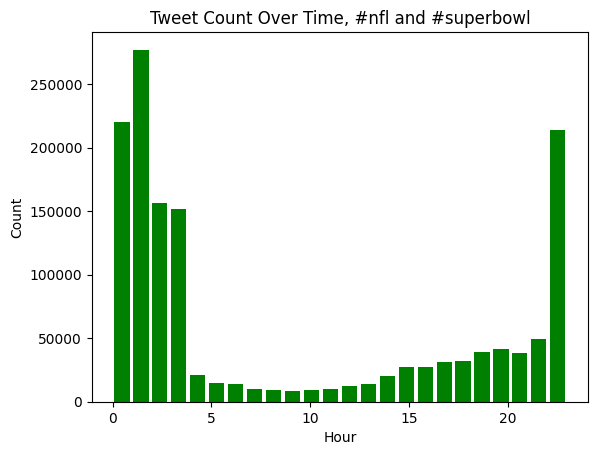

In [ ]:
# Plot tweet count over time (only consider hour) for #nfl and #superbowl

# Convert times to hours (drop non-hour attributes)
tweet_times_hours = []
for tweet_time in tweet_times:
  tweet_times_hours.append(tweet_time.hour)

# tweet_time_df = pd.DataFrame(tweet_times_hours, columns=["datetime"])
# tweet_time_df.set_index("datetime", inplace=True)
# tweet_time_df["count"] = 1

# resampled_df = tweet_time_df.resample("1H").sum()
# resampled_df.plot(kind="bar")

plt.hist(tweet_times_hours, bins=24, align="mid", rwidth=0.8, color="green")
plt.title("Tweet Count Over Time, #nfl and #superbowl")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

In [ ]:
# Plot tweet count over time for #nfl and #superbowl

tweet_time_df = pd.DataFrame(tweet_times, columns=["datetime"])
tweet_time_df.set_index("datetime", inplace=True)
tweet_time_df["count"] = 1

resampled_df = tweet_time_df.resample("1H").sum()

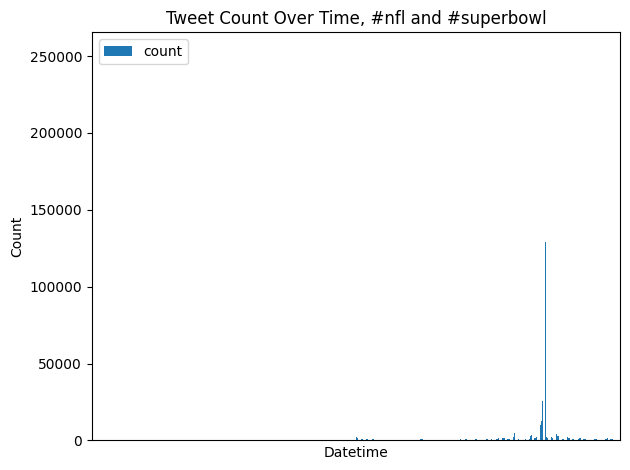

In [ ]:
resampled_df.plot(kind="bar")
plt.title("Tweet Count Over Time, #nfl and #superbowl")
plt.xlabel("Datetime")
plt.ylabel("Count")
# plt.xticks(rotation=45)
# plt.xticks(np.arange(min(tweet_times).toordinal(), max(tweet_times).toordinal(), (max(tweet_times) - min(tweet_times)).total_seconds() / 3600 / 10))
# plt.xticks(range(0, len(resampled_df.index), len(resampled_df.index) // 300), resampled_df.index, rotation=45)
plt.xticks([], [])
# plt.xticks(np.arange(resampled_df.index.min(), resampled_df.index.max(), 300))
# plt.xticks()
plt.tight_layout()
plt.show()

# Relative Time of Posting Prediction

In [ ]:
!pip install textblob

Found existing installation: textblob 0.18.0.post0
Uninstalling textblob-0.18.0.post0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/textblob-0.18.0.post0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/textblob/*
Proceed (Y/n)? Y
  Successfully uninstalled textblob-0.18.0.post0
  Using cached textblob-0.18.0.post0-py3-none-any.whl (626 kB)


In [ ]:
# Feature engineering
# Sample data, split into train and test splits, and extract important features and target

X_train, X_test, y_train, y_test = [[] for _ in range(4)]
tweet_time_classes = {
    0: "before superbowl",
    1: "during superbowl",
    2: "after superbowl",
}

superbowl_start_time = datetime.datetime(2015, 2, 1, 15, 30)
superbowl_end_time = datetime.datetime(2015, 2, 1, 19, 30)

files = [
  "tweet data/tweets_#gohawks.txt",
  "tweet data/tweets_#gopatriots.txt",
  "tweet data/tweets_#nfl.txt",
  "tweet data/tweets_#patriots.txt",
  "tweet data/tweets_#sb49.txt",
  "tweet data/superbowl_1.txt",
  "tweet data/superbowl_2.txt",
  "tweet data/superbowl_3.txt",
]

for fname in files:
  print (f"PROCESSING {fname}...")
  with open(fname, "r") as f:
    data = f.read().strip().split("\n")

  if len(data) < 10:
    continue

  sampled_data = random.sample(data, len(data) // 10)

  data = None # clear memory

  data_train, data_test = train_test_split(sampled_data, test_size=0.20, random_state=RANDOM_STATE)

  for i, dataset in enumerate([data_train, data_test]):
    for tweet in dataset:
      tweet_obj = json.loads(tweet)

      # Populate X
      tweet_text = tweet_obj["tweet"]["text"]

      blob = TextBlob(tweet_text)
      sentiment = blob.sentiment
      polarity, subjectivity = sentiment.polarity, sentiment.subjectivity

      favorite_count = int(tweet_obj["tweet"]["favorite_count"])
      impressions = int(tweet_obj["metrics"]["impressions"])
      reply_count = int(tweet_obj["metrics"]["citations"]["replies"])
      retweet_count = int(tweet_obj["metrics"]["citations"]["total"])
      emoji_count = emoji.emoji_count(tweet_text)

      tweet_features = [polarity, subjectivity, favorite_count, impressions, reply_count, retweet_count, emoji_count]
      if i == 0:
        X_train.append(tweet_features)
      else:
        X_test.append(tweet_features)

      # Populate y
      tweet_time_unix = tweet_obj["citation_date"]
      tweet_time_dt = datetime.datetime.fromtimestamp(tweet_time_unix)
      if tweet_time_dt < superbowl_start_time:
        category = 0
      elif tweet_time_dt > superbowl_end_time:
        category = 2
      else:
        category = 1

      if i == 0:
        y_train.append(category)
      else:
        y_test.append(category)

PROCESSING tweet data/tweets_#gohawks.txt...
PROCESSING tweet data/tweets_#gopatriots.txt...
PROCESSING tweet data/tweets_#nfl.txt...
PROCESSING tweet data/tweets_#patriots.txt...
PROCESSING tweet data/tweets_#sb49.txt...
PROCESSING tweet data/superbowl_1.txt...
PROCESSING tweet data/superbowl_2.txt...
PROCESSING tweet data/superbowl_3.txt...


In [ ]:
# Arrays to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
classifier = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=RANDOM_STATE)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print (cm)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print (f"Accuracy: {accuracy}")

[[    3     0 11907]
 [    0     0  2964]
 [    6     0 41597]]
Accuracy: 0.7365830338013705


In [ ]:
# baseline_X = np.random.choice(X_test_scaled, size=len(X_test_scaled) // 100, replace=False)

random_indices = np.random.choice(X_test_scaled.shape[0], size=len(X_test_scaled) // 100, replace=False)

# Index into the array to get the sampled rows
baseline_X = X_test_scaled[random_indices, :]
baseline_y = y_test[random_indices]

print (len(X_test_scaled))
print (X_test_scaled.shape)
print (len(baseline_X))
print (baseline_X.shape)

56477
(56477, 7)
564
(564, 7)


In [ ]:
ac = AgglomerativeClustering(n_clusters=len(tweet_time_classes), linkage="ward")
y_pred_ac = ac.fit_predict(baseline_X)

In [ ]:
# Confusion Matrix
cm = confusion_matrix(baseline_y, y_pred_ac)
print (cm)

# Accuracy
accuracy = accuracy_score(baseline_y, y_pred_ac)
print (f"Accuracy: {accuracy}")

[[ 87  34   5]
 [ 10  19   0]
 [225 166  18]]
Accuracy: 0.2198581560283688


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, max_iter=1000, n_init=30)
y_pred_km = kmeans.fit_predict(baseline_X)

In [ ]:
# Confusion Matrix
cm = confusion_matrix(baseline_y, y_pred_km)
print (cm)

# Accuracy
accuracy = accuracy_score(baseline_y, y_pred_km)
print (f"Accuracy: {accuracy}")

[[ 89  33   4]
 [ 10  19   0]
 [237 160  12]]
Accuracy: 0.2127659574468085


In [ ]:
# Classifier
clf = GaussianNB()
y_pred_gnb = clf.fit(X_train_scaled, y_train).predict(baseline_X)

In [ ]:
# Confusion Matrix
cm = confusion_matrix(baseline_y, y_pred_gnb)
print (cm)

# Accuracy
accuracy = accuracy_score(baseline_y, y_pred_gnb)
print (f"Accuracy: {accuracy}")

[[  5 119   2]
 [  0  29   0]
 [  9 388  12]]
Accuracy: 0.08156028368794327


In [ ]:
from tensorflow.keras.utils import to_categorical

baseline_y_one_hot_encoded = to_categorical(baseline_y, num_classes=3)
y_train_one_hot_encoded = to_categorical(y_train, num_classes=3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Dense(64, input_shape=(7,), activation="relu"),  # Input layer with 10 features and hidden layer with 64 neurons
    Dense(64, activation="relu"),  # Another hidden layer
    Dense(3, activation="softmax")  # Output layer with 3 neurons (one for each class)
])

# Compile the model
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 4867 (19.01 KB)
Trainable params: 4867 (19.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train_scaled, y_train_one_hot_encoded, epochs=1, batch_size=10, validation_split=0.2)
_, accuracy = model.evaluate(baseline_X, baseline_y_one_hot_encoded)
print (f"Accuracy: {accuracy}")

18/18 [==============================] - 0s 2ms/step - loss: 0.6626 - accuracy: 0.7252
Accuracy: 0.7251772880554199


# Hashtag Prediction

In [ ]:
import json
import numpy as np
import random
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

def load_data_with_labels(files, sample_rate=0.01):
    texts = []
    labels = []
    # Define label assignment based on the file name
    hashtag_to_label = {
        "tweets_#gohawks.txt": "#gohawks",
        "tweets_#gopatriots.txt": "#gopatriots",
        "tweets_#nfl.txt": "#nfl",
        "tweets_#patriots.txt": "#patriots",
        "tweets_#sb49.txt": "#sb49",
    }
    for file_path in files:
        label = hashtag_to_label[file_path.split('/')[-1]]  # Determine label from the file name
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            # If sample_rate is less than 1, sample the lines; otherwise, use all lines
            sampled_lines = random.sample(lines, int(len(lines) * sample_rate)) if sample_rate < 1 else lines

            for line in sampled_lines:
                data = json.loads(line)
                tweet_text = data['tweet']['text']
                texts.append(tweet_text)
                labels.append(label)  # Use the string label directly
    return texts, labels

# Load the data with labels
sample_rate = 0.1  # Adjust the sample rate as needed
texts, labels = load_data_with_labels(files, sample_rate)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Initialize the vectorizer
vectorizer = HashingVectorizer(n_features=2**16, alternate_sign=False)

# Initialize the classifier
classifier = SGDClassifier(loss='log', penalty='l2', max_iter=5000, tol=1e-3, random_state=42)

# Create the pipeline
pipeline = make_pipeline(vectorizer, classifier)

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Model accuracy: 0.823224323736762


# Tweet Engagement

In [ ]:
import json
import numpy as np
import pandas as pd
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

def load_data(file_paths, sample_rate=0.1):
    data = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            sampled_lines = random.sample(lines, int(len(lines) * sample_rate)) if sample_rate < 1 else lines
            for line in sampled_lines:
                tweet = json.loads(line)
                data.append({
                    "text": tweet['tweet']['text'],
                    "contains_url": int('urls' in tweet['tweet']['entities'] and len(tweet['tweet']['entities']['urls']) > 0),
                    "num_hashtags": len(tweet['tweet']['entities']['hashtags']),
                    "tweet_length": len(tweet['tweet']['text']),
                    "posting_time": pd.to_datetime(tweet['tweet']['created_at']).hour,
                    "impressions": tweet['metrics']['impressions']
                })
    return pd.DataFrame(data)

files = [
    "tweet data/tweets_#gohawks.txt",
    "tweet data/tweets_#gopatriots.txt",
    "tweet data/tweets_#nfl.txt",
    "tweet data/tweets_#patriots.txt",
    "tweet data/tweets_#sb49.txt",
]

df = load_data(files, sample_rate=0.1)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
average_impressions = df['impressions'].mean()
print(f"Average impressions: {average_impressions}")

Average impressions: 270.8749512138006


In [ ]:
len(df)

20283

In [ ]:
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV

df['log_impressions'] = np.log1p(df['impressions'])

sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

tfidf_vectorizer = TfidfVectorizer(max_features=2000)
X_text_tfidf = tfidf_vectorizer.fit_transform(df['text'])

svd = TruncatedSVD(n_components=500, random_state=42)
X_text_reduced = svd.fit_transform(X_text_tfidf)

X_numerical = df[['contains_url', 'num_hashtags', 'tweet_length', 'posting_time', 'sentiment']].values
X_combined = np.hstack((X_text_reduced, X_numerical))

y = df['log_impressions'].values

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

xgb_regressor = XGBRegressor(n_estimators=500, learning_rate=0.005, max_depth=5, random_state=42)
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)
y_pred_inverse_transformed = np.expm1(y_pred)
y_test_inverse_transformed = np.expm1(y_test)

mse = mean_squared_error(y_test_inverse_transformed, y_pred_inverse_transformed)
print(f"Mean Squared Error after inverse log transformation: {mse}")


Mean Squared Error after inverse log transformation: 1135.104428877476
